In [1]:
import pandas as pd
import re
from datetime import datetime
import missingno as mg
import numpy as np

In [2]:
fusion = pd.read_csv('/Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/scraping/allocinescraper/allocinescraper/fusionV3.csv', sep= ';')

In [3]:
pd.set_option('display.max_columns', None)
fusion.head()

,film_id,titre_jpbox,genre_principale,genres,date_sortie_france,date_sortie_usa,duree_minutes,synopsis_x,realisateur,acteurs,pays_origine,budget,box_office_demarrage,box_office_france,recette_usa,recette_monde,image_url,note_moyenne,titre_clean,titre_allocine,film_url,film_image_url,release_date,duration,age_classification,producers,director,top_stars,press_rating,viewer_rating,languages,distributor,year_of_production,film_nationality,filming_secrets,fr_entry_week,us_entry_week,fr_entries,us_entries,awards,associated_genres,press_critics_count,viewer_critics_count,broadcast_category,trailer_views,synopsis_y
0,20941,"Abigail, le pouvoir de l'Elue",Fantasy,NaN,08/01/2020,00/00/0000,51.0,"Un siècle après le début de la Contamination, ...",NaN,NaN,NaN,20 000 000 $,NaN,NaN,- $,1 835 634 $,https://www.jpbox-office.com/cinema/images/pos...,NaN,abigail le pouvoir de lelue,"Abigail, le pouvoir de l'Elue",https://www.allocine.fr/film/fichefilm_gen_cfi...,https://fr.web.img6.acsta.net/c_310_420/pictur...,8 janvier 2020,1h 51min,NaN,"Aleksandr Boguslavskiy,Dmitriy Zhigalov",Aleksandr Boguslavskiy,"Tinatin Dalakishvili,Eddie Marsan,Rinal Mukham...",1.9,1.9,Anglais,Condor Distribution,2019.0,"U.S.A.,Russie",-,NaN,NaN,NaN,NaN,NaN,"Action,Fantastique","241 notes, 40 critiques","241 notes, 40 critiques",en VOD,"47 731,vues","Un siècle après le début de la Contamination, ..."
1,10280,Wolfman,Fantasy,NaN,10/02/2010,12/02/2010,42.0,Lawrence Talbot est un aristocrate torturé que...,Joe Johnston,Emily Blunt | Benicio Del Toro | Anthony Hopki...,NaN,150 000 000 $,214 497,334 885,61 937 495 $,77 810 085 $,https://www.jpbox-office.com/cinema/images/pos...,3.0,wolfman,Wolfman,https://www.allocine.fr/film/fichefilm_gen_cfi...,https://fr.web.img5.acsta.net/c_310_420/medias...,10 février 2010,1h 43min,Interdit - 12 ans,"Joe Johnston,Andrew Kevin Walker,David Self",Joe Johnston,"Benicio Del Toro,Anthony Hopkins,Emily Blunt",3.1,2.4,"Anglais, Roumain",Universal Pictures International France,2010.0,NaN,9 anecdotes,10 au 17 février 2010,12 au 15 février 2010,214 497,30 627 000,1 prix et 2 nominations,"Fantastique,Epouvante-horreur,Thriller",14 critiques,"4274 notes, 791 critiques",en salle,NaN,Lawrence Talbot est un aristocrate torturé que...
2,19775,L'Art du mensonge,Drame,NaN,01/01/2020,15/11/2019,50.0,"Escroc professionnel, Roy Courtnay a déjà en v...",Bill Condon,Ian McKellen | Helen Mirren,NaN,10 000 000 $,66 229,105 205,17 156 058 $,11 200 000 $,https://www.jpbox-office.com/cinema/images/pos...,4.0,lart du mensonge,L'Art du mensonge,https://www.allocine.fr/film/fichefilm_gen_cfi...,https://fr.web.img6.acsta.net/c_310_420/pictur...,1 janvier 2020,1h 50min,NaN,"Bill Condon,Jeffrey Hatcher",Bill Condon,"Helen Mirren,Ian McKellen,Russell Tovey",2.7,3.5,Anglais,Warner Bros. France,2019.0,"U.S.A.,Canada",2 anecdotes,01 au 8 janvier 2020,15 au 18 novembre 2019,66 229,5 605 051,NaN,"Drame,Thriller",16 critiques,"1847 notes, 186 critiques",en salle,NaN,"Escroc professionnel, Roy Courtnay a déjà en v..."
3,11195,Une vie toute neuve,Drame,NaN,06/01/2010,00/00/0000,32.0,"Séoul, 1975. Jinhee a 9 ans. Son père la place...",NaN,NaN,NaN,NaN,16 820,60 220,NaN,NaN,https://www.jpbox-office.com/cinema/images/pos...,3.0,une vie toute neuve,Une vie toute neuve,https://www.allocine.fr/film/fichefilm_gen_cfi...,https://fr.web.img3.acsta.net/c_310_420/medias...,6 janvier 2010,1h 32min,NaN,Ounie Lecomte,Ounie Lecomte,"Kim Sae-Ron,Park Doyeon,Park Myeong-Shin",3.7,3.8,Coréen,Diaphana Films,2008.0,"France,Corée du Sud",1 anecdote,06 au 13 janvier 2010,NaN,16 820,NaN,1 prix et 1 nomination,Drame,19 critiques,"274 notes, 56 critiques",en salle,NaN,"Séoul, 1975. Jinhee a 9 ans. Son père la place..."
4,11019,"New York, I Love You",Court-métrage,NaN,14/04/2010,16/10/2009,40.0,"Depuis l'invention du cinéma, New York n'a jam...",Brett Ratner | Yvan Attal,Bradley Cooper | Orlando Bloom | Andy Garcia |...,NaN,14 700 000 $,39 797,103 782,1 585 787 $,6 427 072 $,https://www.jpbox-office.com/

In [4]:
df_fusion = fusion[[
    'film_id', 'titre_allocine', 'image_url',
    'year_of_production', 'release_date', 'date_sortie_usa',
    'film_nationality', 'languages', 'duration', 'age_classification',
    'director', 'top_stars', 'producers',
    'genre_principale', 'associated_genres', 'synopsis_y', 'filming_secrets', 'awards', 'broadcast_category',
    'distributor',
    'budget', 'box_office_demarrage', 'box_office_france', 'fr_entry_week', 'us_entries', 'us_entry_week', 'recette_usa', 'recette_monde',  
    'press_rating', 'viewer_rating', 'press_critics_count', 'viewer_critics_count', 'trailer_views'
]].copy()

# Rename French or unclear column names
df_fusion.rename(columns={
    'titre_allocine': 'film_title',
    "associated_genres" : 'associated_genres_allocine',
    'genre_principale': 'main_genre_jpboxoffice',
    'release_date': 'release_date_france',
    'us_entries': 'opening_week_us',
    'date_sortie_usa': 'release_date_usa',
    'film_nationality': 'nationality',
    'synopsis_y': 'synopsis',
    'box_office_demarrage': 'opening_week_france',
    'recette_usa': 'revenue_usa',
    'recette_monde': 'revenue_world'
}, inplace=True)

In [5]:
# film_title: remove extra spaces
df_fusion['film_title'] = df_fusion['film_title'].str.strip()

In [6]:
# Mapping for French month names to numbers
month_mapping = {
    'janvier': '01',
    'février': '02',
    'mars': '03',
    'avril': '04',
    'mai': '05',
    'juin': '06',
    'juillet': '07',
    'août': '08',
    'septembre': '09',
    'octobre': '10',
    'novembre': '11',
    'décembre': '12'
}


def parse_release_date(date_str):
    """ 
    Converts French date strings (e.g., "12 mars 2025", "octobre 2022")
    into "DD-MM-YYYY" or "MM-YYYY" format.
    Returns None if the input is invalid or not recognized.
    """
    
    # Return None if the input is missing (NaN)
    if pd.isna(date_str):
        return None

    # Split the input string into parts (words)
    parts = date_str.strip().split()

    # If the format is "day month year" (3 parts)
    if len(parts) == 3:
        day, month_fr, year = parts

        # Convert French month to numeric format
        month = month_mapping.get(month_fr.lower())

        # Return None if the month is not valid
        if not month:
            return None

        try:
            # Build a datetime object and return the date as "DD-MM-YYYY"
            date_obj = datetime.strptime(f"{day.zfill(2)}-{month}-{year}", "%d-%m-%Y")
            return date_obj.strftime("%d-%m-%Y")
        except ValueError:
            # Handle invalid day/month/year combinations (e.g., "31 février")
            return None

    # If the format is "month year" (2 parts)
    elif len(parts) == 2:
        month_fr, year = parts

        # Convert French month to numeric format
        month = month_mapping.get(month_fr.lower())

        # Return formatted string or None if the month is invalid
        return None if not month else f"{month}-{year}"

    # If the format is not recognized, return None
    else:
        return None
    
# release_date: reformat date
df_fusion['release_date_france'] = df_fusion['release_date_france'].apply(parse_release_date)

In [7]:
# Format 'release_date_usa' to use '-' as separator
df_fusion['release_date_usa'] = df_fusion['release_date_usa'].astype(str).str.replace('/', '-', regex=False)

In [8]:
def get_season(date_str):
    """
    Given a date string in "YYYY-MM-DD", returns the season (Winter, Spring, Summer, Autumn).
    """
    if pd.isna(date_str):
        return None
    try:
        dt = datetime.strptime(date_str, "%d-%m-%Y")
    except ValueError:
        return None
    month = dt.month
    # Northern hemisphere seasons
    if month in [2, 1, 12]:
        return "Winter"
    elif month in [5, 4, 3]:
        return "Spring"
    elif month in [8, 7, 6]:
        return "Summer"
    else:
        return "Autumn"
    
# Derive season from release_date
df_fusion['release_season'] = df_fusion['release_date_france'].apply(get_season)

In [9]:
def duration_to_minutes(duration_str):
    # Converts "1h 26min" into integer minutes (86)
    if pd.isna(duration_str):
        return None
    if match := re.search(r'(\d+)\s*h\s*(\d+)?', duration_str):
        hours = int(match.group(1))
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours * 60 + minutes
    return None

# duration: convert to minutes
df_fusion['duration_minutes'] = df_fusion['duration'].apply(duration_to_minutes)

In [10]:
# age_classification: remove extra spaces
df_fusion['age_classification'] = df_fusion['age_classification'].str.strip()

In [11]:
df_fusion.head()

,film_id,film_title,image_url,year_of_production,release_date_france,release_date_usa,nationality,languages,duration,age_classification,director,top_stars,producers,main_genre_jpboxoffice,associated_genres_allocine,synopsis,filming_secrets,awards,broadcast_category,distributor,budget,opening_week_france,box_office_france,fr_entry_week,opening_week_us,us_entry_week,revenue_usa,revenue_world,press_rating,viewer_rating,press_critics_count,viewer_critics_count,trailer_views,release_season,duration_minutes
0,20941,"Abigail, le pouvoir de l'Elue",https://www.jpbox-office.com/cinema/images/pos...,2019.0,08-01-2020,00-00-0000,"U.S.A.,Russie",Anglais,1h 51min,NaN,Aleksandr Boguslavskiy,"Tinatin Dalakishvili,Eddie Marsan,Rinal Mukham...","Aleksandr Boguslavskiy,Dmitriy Zhigalov",Fantasy,"Action,Fantastique","Un siècle après le début de la Contamination, ...",-,NaN,en VOD,Condor Distribution,20 000 000 $,NaN,NaN,NaN,NaN,NaN,- $,1 835 634 $,1.9,1.9,"241 notes, 40 critiques","241 notes, 40 critiques","47 731,vues",Winter,111.0
1,10280,Wolfman,https://www.jpbox-office.com/cinema/images/pos...,2010.0,10-02-2010,12-02-2010,NaN,"Anglais, Roumain",1h 43min,Interdit - 12 ans,Joe Johnston,"Benicio Del Toro,Anthony Hopkins,Emily Blunt","Joe Johnston,Andrew Kevin Walker,David Self",Fantasy,"Fantastique,Epouvante-horreur,Thriller",Lawrence Talbot est un aristocrate torturé que...,9 anecdotes,1 prix et 2 nominations,en salle,Universal Pictures International France,150 000 000 $,214 497,334 885,10 au 17 février 2010,30 627 000,12 au 15 février 2010,61 937 495 $,77 810 085 $,3.1,2.4,14 critiques,"4274 notes, 791 critiques",NaN,Winter,103.0
2,19775,L'Art du mensonge,https://www.jpbox-office.com/cinema/images/pos...,2019.0,01-01-2020,15-11-2019,"U.S.A.,Canada",Anglais,1h 50min,NaN,Bill Condon,"Helen Mirren,Ian McKellen,Russell Tovey","Bill Condon,Jeffrey Hatcher",Drame,"Drame,Thriller","Escroc professionnel, Roy Courtnay a déjà en v...",2 anecdotes,NaN,en salle,Warner Bros. France,10 000 000 $,66 229,105 205,01 au 8 janvier 2020,5 605 051,15 au 18 novembre 2019,17 156 058 $,11 200 000 $,2.7,3.5,16 critiques,"1847 notes, 186 critiques",NaN,Winter,110.0
3,11195,Une vie toute neuve,https://www.jpbox-office.com/cinema/images/pos...,2008.0,06-01-2010,00-00-0000,"France,Corée du Sud",Coréen,1h 32min,NaN,Ounie Lecomte,"Kim Sae-Ron,Park Doyeon,Park Myeong-Shin",Ounie Lecomte,Drame,Drame,"Séoul, 1975. Jinhee a 9 ans. Son père la place...",1 anecdote,1 prix et 1 nomination,en salle,Diaphana Films,NaN,16 820,60 220,06 au 13 janvier 2010,NaN,NaN,NaN,NaN,3.7,3.8,19 critiques,"274 notes, 56 critiques",NaN,Winter,92.0
4,11019,"New York, I Love You",https://www.jpbox-office.com/cinema/images/pos...,2008.0,14-04-2010,16-10-2009,NaN,Anglais,1h 43min,NaN,Mira Nair,"Hayden Christensen,Rachel Bilson,Andy Garcia","Mira Nair,Fatih Akın,Yvan Attal",Court-métrage,Comédie dramatique,"Depuis l'invention du cinéma, New York n'a jam...",15 anecdotes,NaN,en salle,Metropolitan FilmExport,14 700 000 $,39 797,103 782,14 au 21 avril 2010,NaN,NaN,1 585 787 $,6 427 072 $,2.8,2.7,16 critiques,"1472 notes, 166 critiques",NaN,Spring,103.0


In [12]:
def split_list(text, separator=','):
    # Splits a string into a trimmed list
    if pd.isna(text) or text.strip() == "":
        return []
    return [x.strip() for x in text.split(separator) if x.strip()]

# producers: split into list and create a producer count column
df_fusion['producers_list'] = df_fusion['producers'].apply(lambda x: split_list(x))
df_fusion['producers_count'] = df_fusion['producers_list'].apply(len)

# top_stars: split into list and create a top_stars count column
df_fusion['top_stars_list'] = df_fusion['top_stars'].apply(lambda x: split_list(x))
df_fusion['top_stars_count'] = df_fusion['top_stars_list'].apply(len)

# language: split into list and create a languages count column
df_fusion['languages_list'] = df_fusion['languages'].apply(lambda x: split_list(x))
df_fusion['languages_count'] = df_fusion['languages_list'].apply(len)

# nationality (film): split into list and create a nationality count column
df_fusion['nationality_list'] = df_fusion['nationality'].apply(lambda x: split_list(x))
df_fusion['nationality_list_count'] = df_fusion['nationality_list'].apply(len)

# associated_genres: keep only count (drop the list version)
df_fusion['associated_genres_allocine_list'] = df_fusion['associated_genres_allocine'].apply(lambda x: split_list(x))
df_fusion['associated_genres_allocine_count'] = df_fusion['associated_genres_allocine_list'].apply(len)

In [13]:
# director: clean spaces
df_fusion['director'] = df_fusion['director'].str.strip()

In [14]:
def parse_week_period(period_text):
    """
    Given a French week period string like "05 au 12 mars 2025",
    extract start and end dates and return a tuple:
      (formatted_period, iso_week_number)
    where formatted_period is "dd-mm-yyyy – dd-mm-yyyy" using the same month/year for both dates.
    """
    if pd.isna(period_text) or period_text.strip() == "":
        return None, None

    # Pattern expecting something like: "05 au 12 mars 2025"
    pattern = r'(\d{1,2})\s*au\s*(\d{1,2})\s*(\w+)\s*(\d{4})'
    match = re.search(pattern, period_text.strip(), re.IGNORECASE)
    if not match:
        return period_text, None

    start_day, end_day, month_fr, year = match.groups()
    month = month_mapping.get(month_fr.lower(), '01')

    # Format dates with hyphens
    start_date_str = f"{start_day.zfill(2)}-{month}-{year}"
    end_date_str = f"{end_day.zfill(2)}-{month}-{year}"

    # Determine ISO week number using the start date
    try:
        dt_start = datetime.strptime(f"{year}-{month}-{start_day.zfill(2)}", "%Y-%m-%d")
        iso_week = dt_start.isocalendar()[1]
    except Exception:
        iso_week = None

    formatted_period = f"{start_date_str} – {end_date_str}"
    return formatted_period, iso_week

# Process week periods for fr_entry_week and us_entry_week
for col in ['fr_entry_week', 'us_entry_week']:
    period, iso_week = zip(*df_fusion[col].apply(lambda x: parse_week_period(x)))
    df_fusion[f'{col}'] = period
    df_fusion[f'{col}_iso_week'] = [int(i) if pd.notna(i) else 0 for i in iso_week]

In [15]:
def extract_number(text):
    # Remove any spaces and then check if the remaining text is a number
    if pd.isna(text):
        return None
    cleaned = text.replace(" ", "")
    try:
        return int(cleaned)
    except ValueError:
        # Fallback: extract the first sequence of digits if conversion fails
        import re
        match = re.search(r'(\d+)', cleaned)
        return int(match.group(1)) if match else None

# filming_secrets: extract number and cast to int (if missing, set to 0)
df_fusion['filming_secrets_num'] = df_fusion['filming_secrets'].apply(lambda x: extract_number(x))
df_fusion['filming_secrets_num'] = df_fusion['filming_secrets_num'].apply(lambda x: int(x) if pd.notna(x) else 0)

# Process fr_entries and us_entries as numbers (remove spaces and cast to int)
for col in ['opening_week_france', 'opening_week_us']:
    df_fusion[f'{col}_num'] = df_fusion[col].apply(lambda x: extract_number(x))
    df_fusion[f'{col}_num'] = df_fusion[f'{col}_num'].apply(lambda x: int(x) if pd.notna(x) else 0)

# press_critics_count: extract number and cast to int
df_fusion['press_critics_count_num'] = df_fusion['press_critics_count'].apply(lambda x: extract_number(x))
df_fusion['press_critics_count_num'] = df_fusion['press_critics_count_num'].apply(lambda x: int(x) if pd.notna(x) else 0)

In [16]:
def clean_awards(text):
    # Separates awards and nominations from a string like "1 prix et 1 nomination" or "20 nominations"
    awards = None
    nominations = None
    if pd.isna(text) or text.strip() == "":
        return awards, nominations
    match_awards = re.search(r'(\d+)\s*prix', text, re.IGNORECASE)
    match_nominations = re.search(r'(\d+)\s*nomination', text, re.IGNORECASE)
    if match_awards:
        awards = int(match_awards.group(1))
    if match_nominations:
        nominations = int(match_nominations.group(1))
    return awards, nominations

# awards: separate awards and nominations and cast to int (defaulting to 0)
awards_data = df_fusion['awards'].apply(clean_awards)
df_fusion['award_count'] = awards_data.apply(lambda x: int(x[0]) if pd.notna(x[0]) else 0)
df_fusion['nomination_count'] = awards_data.apply(lambda x: int(x[1]) if pd.notna(x[1]) else 0)

# Create total awards+nomination column, as int
df_fusion['total_awards_nomination'] = df_fusion.apply(lambda row: int(row['award_count']) + int(row['nomination_count']), axis=1)

In [17]:
def clean_viewer_critics(text):
    # Splits a string like "566 notes, 241 critiques" into a tuple (notes, critiques)
    notes = None
    critiques = None
    if pd.isna(text) or text.strip()=="":
        return notes, critiques
    match_notes = re.search(r'(\d+)\s*notes', text, re.IGNORECASE)
    match_critiques = re.search(r'(\d+)\s*critiques', text, re.IGNORECASE)
    if match_notes:
        notes = int(match_notes.group(1))
    if match_critiques:
        critiques = int(match_critiques.group(1))
    return notes, critiques

# viewer_critics_count: split into notes and critiques and cast them to int
viewer_data = df_fusion['viewer_critics_count'].apply(clean_viewer_critics)
df_fusion['viewer_notes'] = viewer_data.apply(lambda x: int(x[0]) if pd.notna(x[0]) else 0)
df_fusion['viewer_critiques'] = viewer_data.apply(lambda x: int(x[1]) if pd.notna(x[1]) else 0)

In [18]:
def extract_trailer_views_count(text):
    """
    Extracts the integer view count from a trailer views text, handling non-breaking spaces, commas, and non-numeric characters.
    Example: "30 556,vues" → 30556
    """
    if pd.isna(text):
        return pd.NA
    cleaned = re.sub(r"[^\d]", "", str(text))
    return int(cleaned) if cleaned else pd.NA

# trailer_views: extract number of views
df_fusion['trailer_views_num'] = df_fusion['trailer_views'].apply(extract_trailer_views_count)

In [19]:
# synopsis: add a column for the length of the synopsis
df_fusion['synopsis_length'] = df_fusion['synopsis'].apply(lambda x: len(x) if pd.notna(x) else 0)

In [20]:
def extract_year(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, datetime):
        return val.year
    if isinstance(val, float):
        return int(val) if not pd.isna(val) else pd.NA
    if isinstance(val, str):
        try:
            return pd.to_datetime(val).year
        except Exception:
            return np.nan
    return np.nan  # fallback for unexpected types

    
# Process year_of_production: extract year and cast to Int64
df_fusion['year_of_production'] = df_fusion['year_of_production'].apply(extract_year).astype('Int64')

In [21]:
df_fusion.loc[df_fusion['film_id'] == 1407, 
                          ['year_of_production', 
                           'release_date_france', 
                           'release_date_us', 
                           'duration', 
                           'distributor', 
                           'duration_minutes', 
                           'top_stars']] = [
                               2016, 
                               '13-04-2016', 
                               '15-04-2016', 
                               '1hr 46mins', 
                               'Walt Disney Studios Motion Pictures',
                                106, 
                                'Neel Sethi,Bill Murray,Ben Kingsley,']

In [28]:
df_fusion.rename(columns={
    'opening_week_france': 'fr_entries',
    'opening_week_us' : 'us_entries',
    'box_office_france' : 'fr_entries_cumul'
}, inplace=True)

<Axes: >

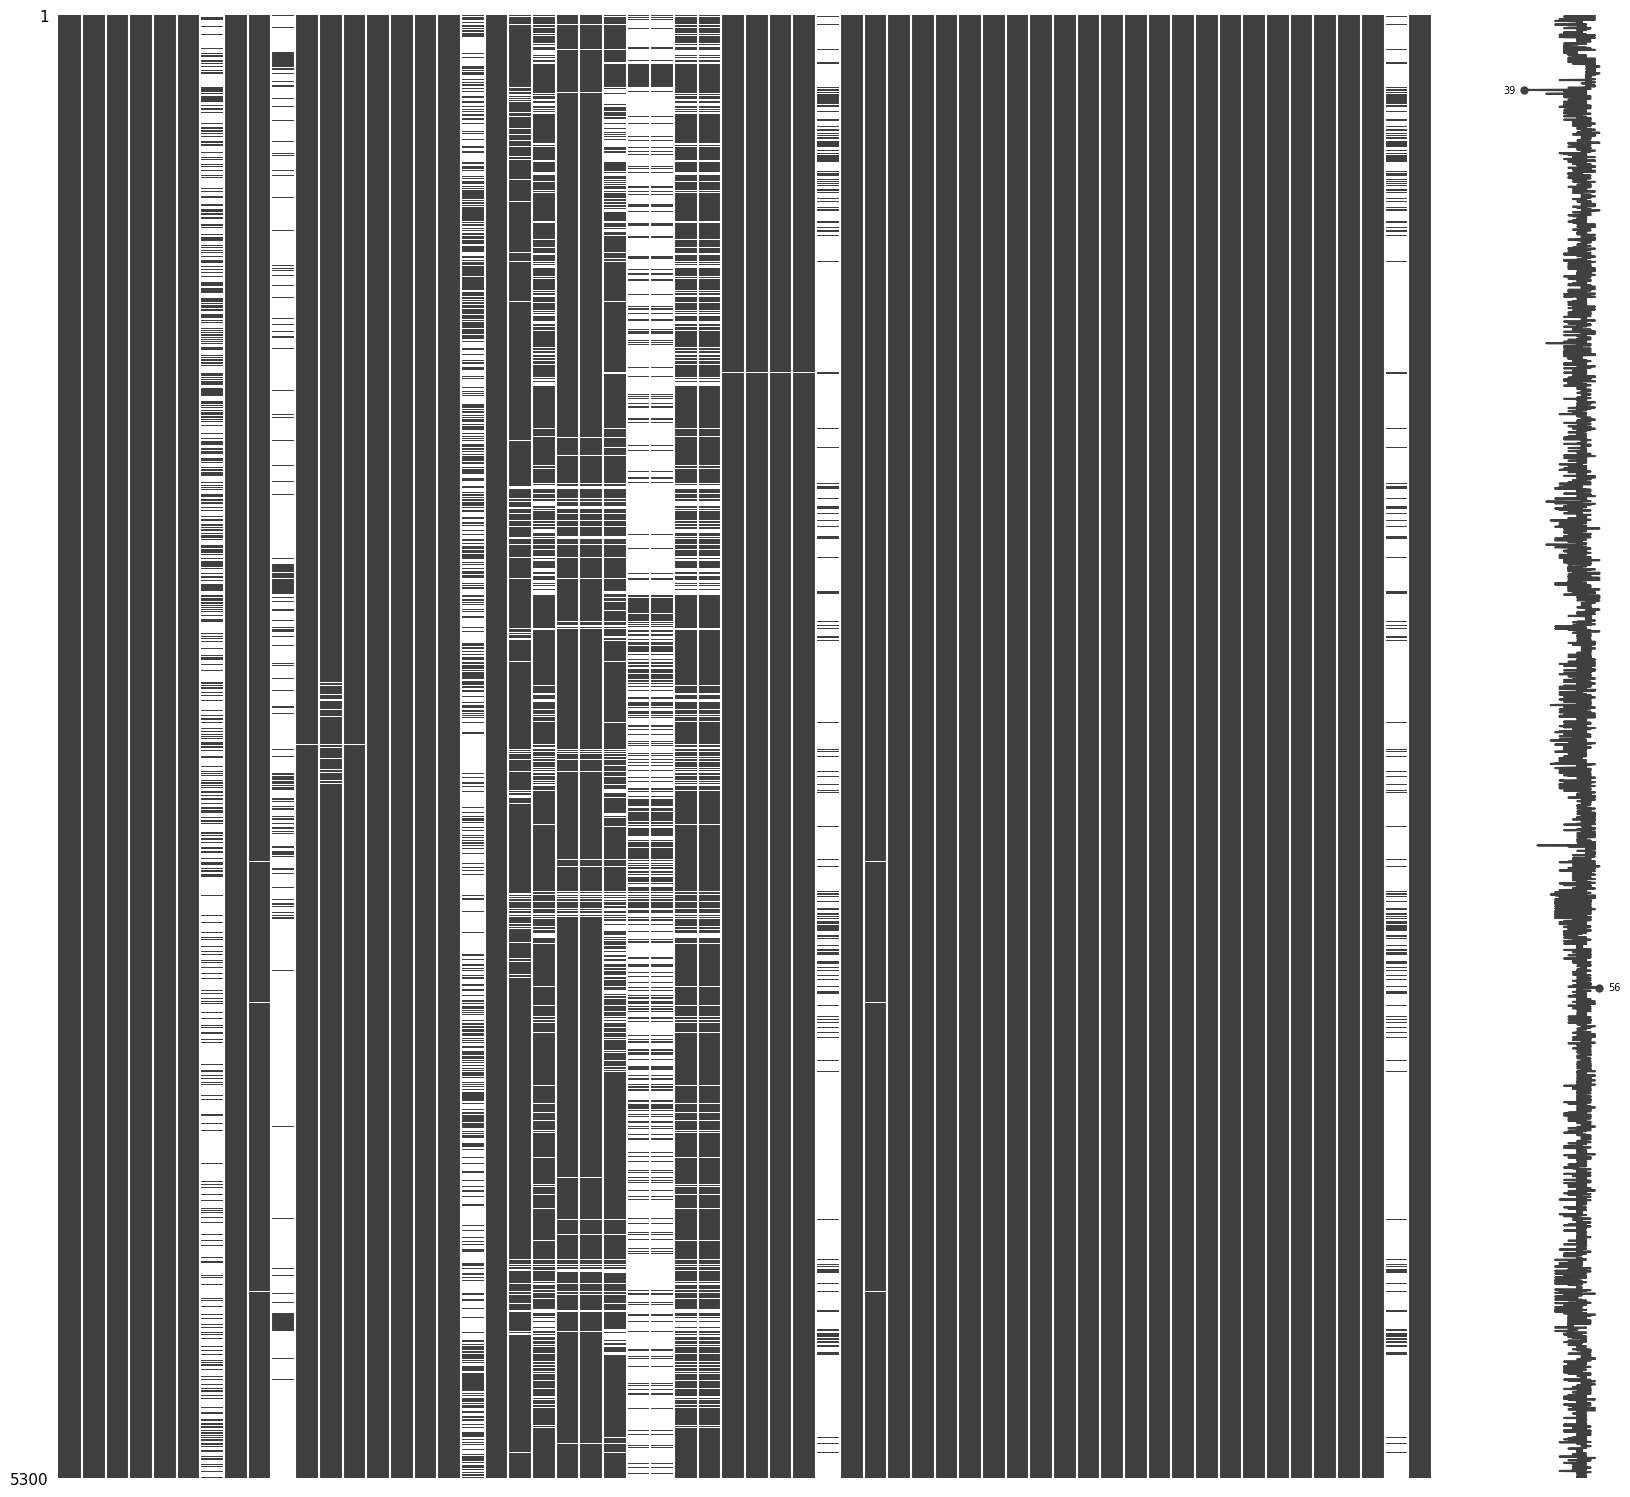

In [23]:
mg.matrix(df_fusion, figsize=(20, 19), fontsize=9)

In [30]:
pd.set_option('display.max_rows', None)
df_fusion.isna().sum()

film_id                                0
film_title                             0
image_url                              0
year_of_production                     0
release_date_france                    0
release_date_usa                       0
nationality                         3710
languages                              0
duration                              11
age_classification                  4703
director                               6
top_stars                             74
producers                              6
main_genre_jpboxoffice                 0
associated_genres_allocine             0
synopsis                               4
filming_secrets                        0
awards                              3164
broadcast_category                     0
distributor                          287
budget                               857
fr_entries                           210
fr_entries_cumul                     210
fr_entry_week                        859
us_entries      

In [32]:
if __name__ == '__main__':
    output_path = '/Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/machine_learning/fusionV3_cleaned.csv'
    
    df_fusion.to_csv(output_path, index=False)
    print(f"Cleaned data saved to {output_path}")

Cleaned data saved to /Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/machine_learning/fusionV3_cleaned.csv
